In [1]:
import random

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.metrics import classification_report, roc_auc_score

import uproot 
import awkward as ak

In [38]:
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams["font.size"] = 22
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['text.usetex'] = False

In [3]:
file = "/home/dejavu/Projects/Samples/qgcal/merged_hist_weight.root"
merged_file = uproot.open(file)

In [4]:
branch_names = ["total_weight", "pu_weight", "mconly_weight", "jet_fire", "jet_pt", "jet_eta", "jet_nTracks", "jet_trackWidth", "jet_trackC1", "jet_trackBDT", "jet_PartonTruthLabelID"]
branches = merged_file["nominal"].arrays(branch_names)

## Event trigger and leadjing jets selection

In [5]:
print("Before applying event trigger:")
print(branches.type)

Before applying event trigger:
148462568 * {"total_weight": float32, "pu_weight": float32, "mconly_weight": float32, "jet_fire": bool, "jet_pt": var * float32, "jet_eta": var * float32, "jet_nTracks": var * float32, "jet_trackWidth": var * float32, "jet_trackC1": var * float32, "jet_trackBDT": var * float32, "jet_PartonTruthLabelID": var * int32}


In [6]:
event_trigger_idx = branches["jet_fire"] == 1
branches = branches[event_trigger_idx]

In [7]:
print("after applying event trigger:")
print(branches.type)

after applying event trigger:
70890262 * {"total_weight": float32, "pu_weight": float32, "mconly_weight": float32, "jet_fire": bool, "jet_pt": var * float32, "jet_eta": var * float32, "jet_nTracks": var * float32, "jet_trackWidth": var * float32, "jet_trackC1": var * float32, "jet_trackBDT": var * float32, "jet_PartonTruthLabelID": var * int32}


In [8]:
# pT cut 
pt_cut_idx = branches["jet_pt"][:,0] > 500000
branches = branches[pt_cut_idx]

pt_max_cut_idx = branches["jet_pt"][:,0] < 2000000 
branches = branches[pt_max_cut_idx]

print("after applying pt cut:")
print(branches.type)


after applying pt cut:
45578596 * {"total_weight": float32, "pu_weight": float32, "mconly_weight": float32, "jet_fire": bool, "jet_pt": var * float32, "jet_eta": var * float32, "jet_nTracks": var * float32, "jet_trackWidth": var * float32, "jet_trackC1": var * float32, "jet_trackBDT": var * float32, "jet_PartonTruthLabelID": var * int32}


In [9]:
# ratio < 1.5
branches = branches[branches["jet_pt"][:,0]/branches["jet_pt"][:,1] < 1.5]

print("after applying the ratio cut:")
print(branches.type)

after applying the ratio cut:
36389203 * {"total_weight": float32, "pu_weight": float32, "mconly_weight": float32, "jet_fire": bool, "jet_pt": var * float32, "jet_eta": var * float32, "jet_nTracks": var * float32, "jet_trackWidth": var * float32, "jet_trackC1": var * float32, "jet_trackBDT": var * float32, "jet_PartonTruthLabelID": var * int32}


In [10]:
# eta cut 
branches = branches[np.abs(branches["jet_eta"][:,0]) < 2.1]
branches = branches[np.abs(branches["jet_eta"][:,1]) < 2.1]

print("after applying the eta cut:")
print(branches.type)

after applying the eta cut:
36389203 * {"total_weight": float32, "pu_weight": float32, "mconly_weight": float32, "jet_fire": bool, "jet_pt": var * float32, "jet_eta": var * float32, "jet_nTracks": var * float32, "jet_trackWidth": var * float32, "jet_trackC1": var * float32, "jet_trackBDT": var * float32, "jet_PartonTruthLabelID": var * int32}


In [11]:
# Get the total_weigt information
total_weight = branches["total_weight"]

# select all the jets from all the events 
dijet_properties = branches[branch_names[4:]][:,:2]

In [12]:
dijet_properties.type

36389203 * {"jet_pt": var * float32, "jet_eta": var * float32, "jet_nTracks": var * float32, "jet_trackWidth": var * float32, "jet_trackC1": var * float32, "jet_trackBDT": var * float32, "jet_PartonTruthLabelID": var * int32}

# pt spectrum

In [13]:
total_weight_np = total_weight.to_numpy()
total_weight_np[total_weight_np>100] = 1

In [ ]:
ak.flatten(branches[total_weight>100].jet_pt)/1000

In [54]:
def draw_pt_spectrum(pt_array, bins, user_weights = None, title = ' ', use_log = True, save = False):
    fig, ax = plt.subplots()
    if user_weights is None:
        ax.hist(pt_array, bins)
    else:
        ax.hist(pt_array/1000, bins, weights = user_weights)
    ax.set_title(title + '$p_{T}$ Spectrum')
    ax.set_xlabel('Jet $p_{\mathrm{T}}$ [GeV]')
    ax.set_ylabel('Number of Jets')
    if use_log:
        ax.set_yscale('log')
    if save:
        fig.savefig(title.replace(' ','_') + 'pt_distribution')
    fig.show()
    

/tmp/ipykernel_242376/1854751280.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


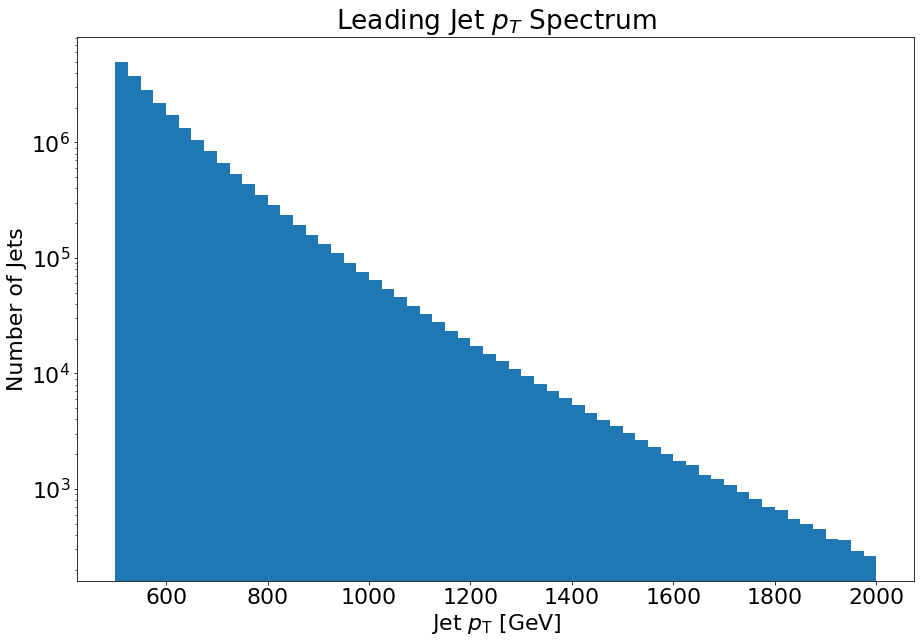

In [55]:
custom_bins = np.linspace(500, 2000, 61)
draw_pt_spectrum(dijet_properties.jet_pt[:,0], custom_bins, 
                 title = 'Leading Jet ', user_weights = total_weight_np, save = True)

/tmp/ipykernel_242376/1854751280.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


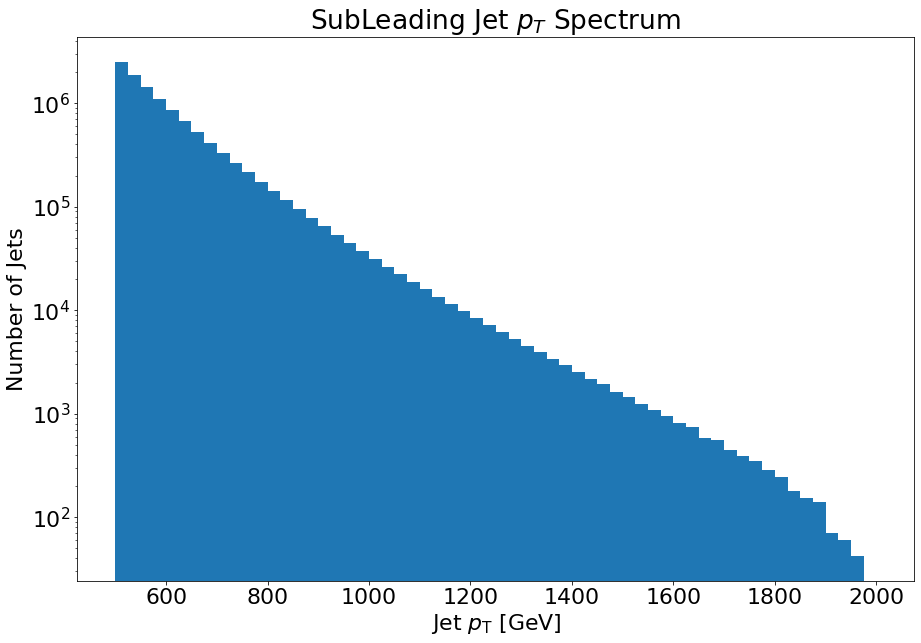

In [56]:
custom_bins = np.linspace(500, 2000, 61)
draw_pt_spectrum(dijet_properties.jet_pt[:,1], custom_bins, 
                 title = 'SubLeading Jet ', user_weights = total_weight_np, save = True)

/tmp/ipykernel_242376/1854751280.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


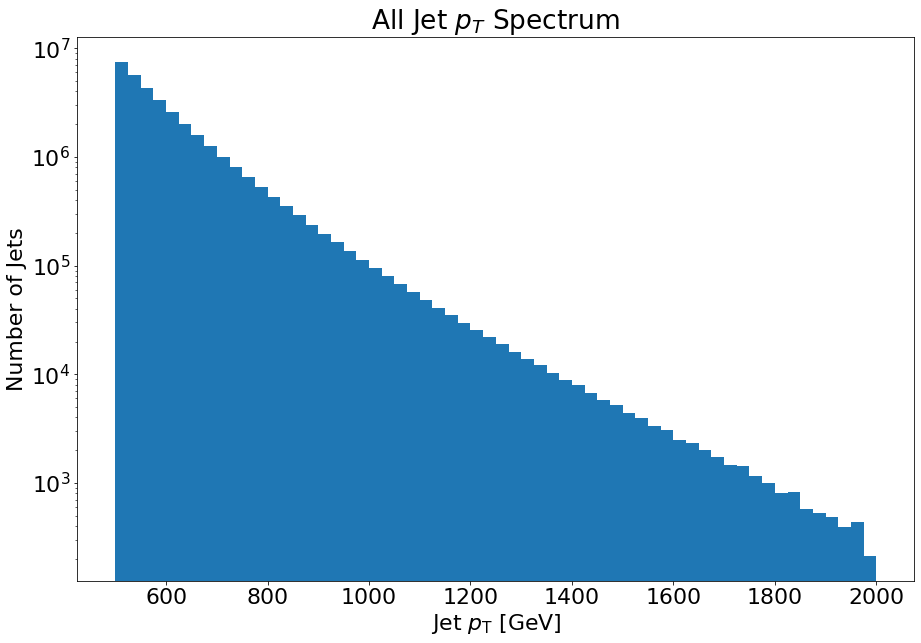

In [66]:
draw_pt_spectrum(ak.flatten(dijet_properties.jet_pt), custom_bins, 
                 title = 'All Jet ', user_weights = np.repeat(total_weight_np, 2), save = True)

In [124]:
dijet_field = dijet_properties.fields[0]
dijet_sample = ak.flatten(dijet_properties[dijet_field], axis=1).to_numpy()[:,None]

for dijet_field in dijet_properties.fields[1:]:
    dijet_sample = np.concatenate( (dijet_sample, ak.flatten(dijet_properties[dijet_field], axis=1).to_numpy()[:, None]), axis=1)


In [130]:
dijet_sample = np.concatenate((dijet_sample, np.repeat(total_weight_np, 2)[:,None]), axis = 1)

In [133]:
np.save("dijet_sample_flatten.npy",dijet_sample)

In [137]:
n_events = len(dijet_sample)//2
dijet_sample = dijet_sample.reshape((n_events, 2, 8))

In [151]:
leading_pt = dijet_sample[:, 0, 0]
leading_weight = dijet_sample[:, 0, -1]
leading_component = dijet_sample[:, 0, -2]

/tmp/ipykernel_242376/1854751280.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


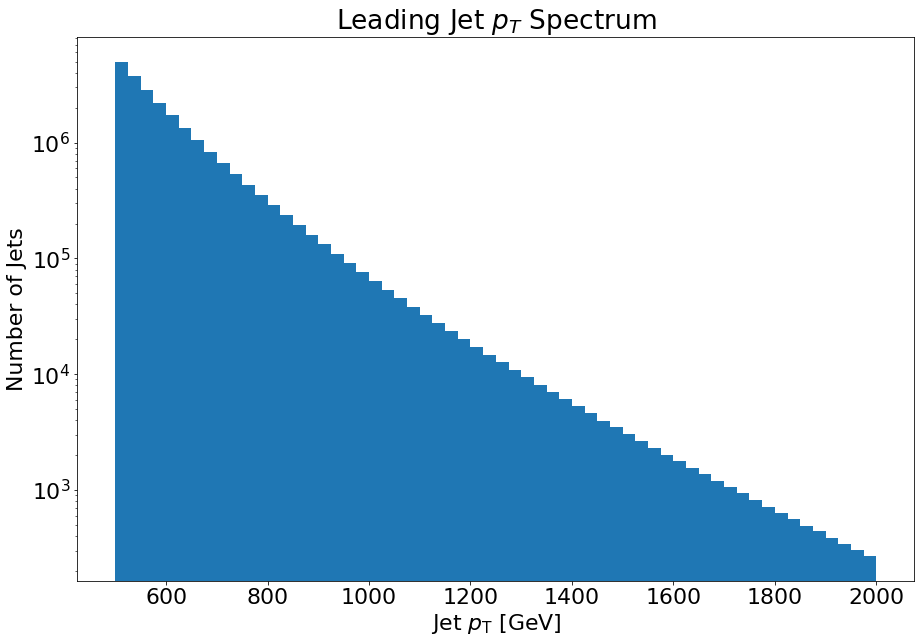

In [141]:
draw_pt_spectrum(leading_pt, custom_bins, 
                 title = 'Leading Jet ', user_weights = leading_weight, save = False)

In [142]:
leading_pt

array([ 513987.34375,  690616.6875 ,  516169.09375, ..., 1883307.75   ,
       1768781.25   , 1674872.375  ])

In [144]:
dijet_properties.jet_pt[:,0].to_numpy()

array([ 513987.34,  690616.7 ,  516169.1 , ..., 1883307.8 , 1768781.2 ,
       1674872.4 ], dtype=float32)

In [148]:
np.save("dijet_sample_event.npy",dijet_sample)

In [146]:
np.array_equal(leading_pt, dijet_properties.jet_pt[:,0].to_numpy())

True

In [147]:
np.array_equal(leading_weight, total_weight_np)

True

# Components

In [153]:
leading_gluon_idx = np.where(leading_component == 21)[0]
leading_b_idx = np.where(leading_component == 5)[0]
leading_c_idx = np.where(leading_component == 4)[0]
leading_light_quarks_idx = np.where((leading_component==1) | (leading_component==2)| (leading_component==3))[0]

In [154]:
leading_gluon_pt = leading_pt[leading_gluon_idx]
leading_b_pt = leading_pt[leading_b_idx]
leading_c_pt = leading_pt[leading_c_idx]
leading_light_quarks_pt = leading_pt[leading_light_quarks_idx]


/tmp/ipykernel_242376/1329648700.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


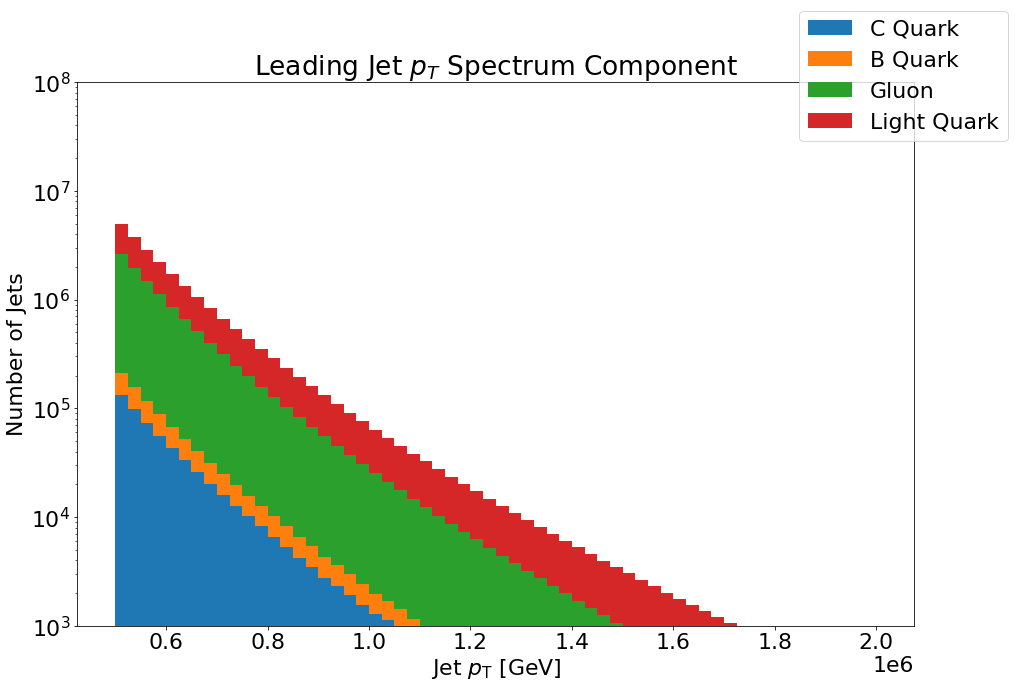

In [159]:
fig, ax = plt.subplots()
custom_bins = np.linspace(500*1E3, 2000*1E3, 61)
ax.hist([leading_c_pt, leading_b_pt, leading_gluon_pt, leading_light_quarks_pt ], custom_bins, 
          weights=[leading_weight[leading_c_idx], leading_weight[leading_b_idx], leading_weight[leading_gluon_idx], leading_weight[leading_light_quarks_idx] ],
          stacked=True, label=["C Quark", "B Quark", "Gluon", "Light Quark"])
ax.set_yscale('log')
ax.set_title( 'Leading Jet $p_{T}$ Spectrum Component')
ax.set_xlabel('Jet $p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel('Number of Jets')
ax.set_ylim(1e3, 1e8)
fig.legend()
fig.show()

/tmp/ipykernel_242376/2286742134.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  weights=np.array([leading_weight[leading_c_idx], leading_weight[leading_b_idx], leading_weight[leading_gluon_idx], leading_weight[leading_light_quarks_idx] ])* 139/36,
/tmp/ipykernel_242376/2286742134.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


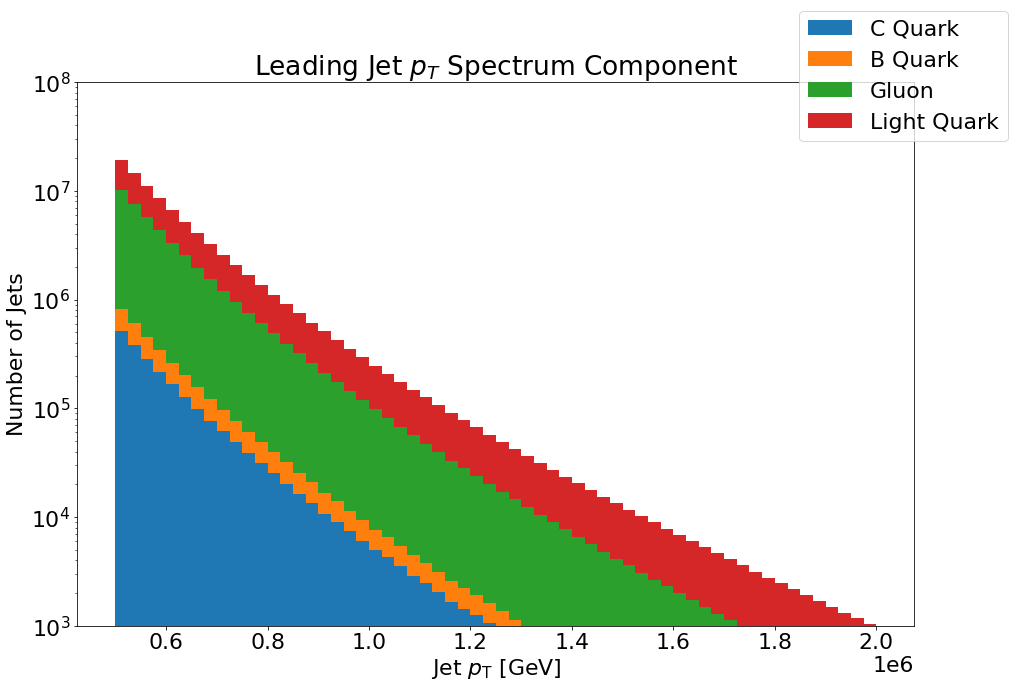

In [161]:
fig, ax = plt.subplots()
custom_bins = np.linspace(500*1E3, 2000*1E3, 61)
ax.hist([leading_c_pt, leading_b_pt, leading_gluon_pt, leading_light_quarks_pt ], custom_bins, 
          weights=np.array([leading_weight[leading_c_idx], leading_weight[leading_b_idx], leading_weight[leading_gluon_idx], leading_weight[leading_light_quarks_idx] ])* 139/36,
          stacked=True, label=["C Quark", "B Quark", "Gluon", "Light Quark"])
ax.set_yscale('log')
ax.set_title( 'Leading Jet $p_{T}$ Spectrum Component')
ax.set_xlabel('Jet $p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel('Number of Jets')
ax.set_ylim(1e3, 1e8)
fig.legend()
fig.show()